In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from string import punctuation 
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('test.csv',encoding='latin1');

In [4]:
train_data.shape

(4815, 9)

In [5]:
train_data.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [6]:
df = train_data[['text', 'sentiment']]

In [7]:
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes

In [8]:
df.head()

,text,sentiment,sentiment_code
0,Last session of the day http://twitpic.com/67ezh,neutral,1
1,Shanghai is also really exciting (precisely -...,positive,2
2,"Recession hit Veronique Branquinho, she has to...",negative,0
3,happy bday!,positive,2
4,http://twitpic.com/4w75p - I like it!!,positive,2


In [9]:
df.dropna(inplace=True)

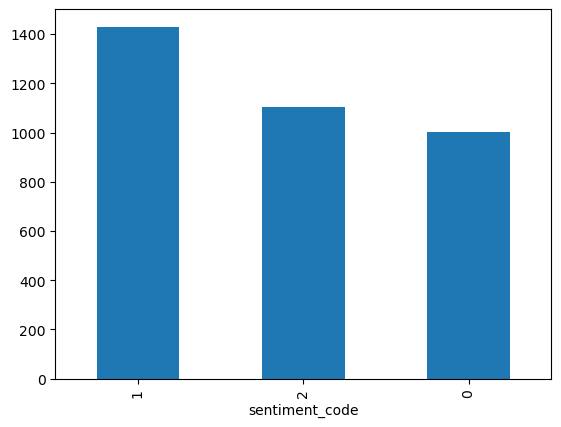

In [10]:
sentiment_distribution = df['sentiment_code'].value_counts(normalize=False)
sentiment_distribution.plot(kind='bar')
plt.show()

In [11]:
df = df.groupby('sentiment_code').apply(lambda x: x.sample(frac=0.5, random_state=42)).reset_index(drop=True)

In [12]:
df.shape

(1767, 3)

In [13]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    if isinstance(text, str):
        words = text.split()        
        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    
    return filtered_text
train_text = [preprocess_text(text) for text in df['text']]

In [14]:
X = train_text
y = df['sentiment_code']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
feature_tf_train = vectorization.fit_transform(X_train)
def vectorization_tf(text):
    vec = vectorization.transform(text)
    return vec
feature_tf_test = vectorization_tf(X_test)

In [17]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec
w2v_model = Word2Vec(X_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to get sentence vector
def sentence_to_w2v(sentence, model, vector_size):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# Get Word2Vec features
w2v_features_train = np.array([sentence_to_w2v(sentence, w2v_model, 100) for sentence in X_train])
w2v_features_test = np.array([sentence_to_w2v(sentence, w2v_model, 100) for sentence in X_test])

In [18]:
def combine(ft_tf, ft_w2v):
    combined = np.hstack((ft_tf.toarray(), ft_w2v))
    return combined
combine_feature_train = combine(feature_tf_train, w2v_features_train )
combine_feature_test = combine(feature_tf_test, w2v_features_test )

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
def early_fusion(x_train, x_test , y_train, y_test):
    svm_model = SVC(kernel = 'linear')
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return

In [20]:
early_fusion(combine_feature_train, combine_feature_test, y_train, y_test)

Accuracy: 0.6016949152542372
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.50      0.56       103
           1       0.53      0.67      0.59       138
           2       0.73      0.61      0.66       113

    accuracy                           0.60       354
   macro avg       0.62      0.59      0.60       354
weighted avg       0.62      0.60      0.60       354



In [21]:
def model_svm(x_train, x_test , y_train, y_test):
    svm_model = SVC(kernel = 'linear')
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return y_pred

In [27]:
pip install scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
def model_logistic(x_train, x_test , y_train, y_test):
    model = XGBClassifier()  # max_iter to ensure convergence
    
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return y_pred

In [33]:
pred_svm1 =  model_svm(feature_tf_train, feature_tf_test, y_train, y_test)
pred_lr1 =  model_logistic(w2v_features_train, w2v_features_test, y_train ,y_test)
pred_svm2 =  model_svm(w2v_features_train, w2v_features_test, y_train ,y_test)
pred_lr2 =  model_logistic(feature_tf_train, feature_tf_test, y_train, y_test)

Accuracy: 0.6045197740112994
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.51      0.56       103
           1       0.53      0.67      0.59       138
           2       0.74      0.61      0.67       113

    accuracy                           0.60       354
   macro avg       0.63      0.60      0.61       354
weighted avg       0.62      0.60      0.61       354

Accuracy: 0.3587570621468927
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.21       103
           1       0.38      0.48      0.42       138
           2       0.40      0.38      0.39       113

    accuracy                           0.36       354
   macro avg       0.34      0.34      0.34       354
weighted avg       0.35      0.36      0.35       354

Accuracy: 0.3898305084745763
Classification Report:
               precision    recall  f1-score   support

           0       0.00 

In [34]:
from scipy import stats
all_preds = np.vstack([pred_svm1, pred_lr1, pred_svm2, pred_lr2])

# Perform majority voting (mode of predictions along axis 0)
final_preds = stats.mode(all_preds, axis=0)[0].flatten()

In [35]:
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Classification Report:\n", classification_report(y_test, final_preds))

Accuracy: 0.5028248587570622
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.36      0.45       103
           1       0.43      0.78      0.56       138
           2       0.75      0.29      0.42       113

    accuracy                           0.50       354
   macro avg       0.60      0.48      0.48       354
weighted avg       0.58      0.50      0.48       354

